Import libraries

In [1]:
import os 
import math
import random
import collections
import numpy as np 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
from pprint import pprint

from scipy.stats import pearsonr

import matplotlib.pyplot as plt 

import torch

from utils import load_pickle, pickle_data, compute_MS_sim, compute_mol_sim

mkdir -p failed for path /afs/csail.mit.edu/u/k/klingmin/.config/matplotlib: [Errno 13] Permission denied: '/afs/csail.mit.edu/u/k/klingmin/.config/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-8hzmcq28 because there was an issue with the default path (/afs/csail.mit.edu/u/k/klingmin/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Settings

In [2]:
data_folder = "/data/rbg/users/klingmin/projects/MS_processing/data/"
splits_folder = "/data/rbg/users/klingmin/projects/MS_processing/data_splits"
IF_scores_folder = "/data/rbg/users/klingmin/projects/ML_MS_analysis/FP_prediction/baseline_models/best_models"
IF_scores_folder_MIST = "/data/rbg/users/klingmin/projects/ML_MS_analysis/FP_prediction/mist/best_models"

model_results_folder = "/data/rbg/users/klingmin/projects/ML_MS_analysis/FP_prediction/baseline_models/best_models"
cache_folder = "./cache/IF_results"
plots_folder = os.path.join(cache_folder, "IF_plots")

if not os.path.exists(plots_folder): os.makedirs(plots_folder)

print(os.listdir(IF_scores_folder))
datasets = ["canopus", "massspecgym", "nist2023"]
splits = ["random", "inchikey_vanilla", "scaffold_vanilla", "LS"]
models = ["binned_", "formula_", "MS_", "MIST_"]

bad_color, good_color = "#3b4cc0", "#f69037"

['massspecgym', 'massspecgym_sieved', 'nist2023', 'nist2023_sieved', 'canopus']


Helper Functions

In [3]:
def compute_CF_match_over_test(test, train):

    test_CF = [p["comment"]["f_pred"] for p in test["peaks"] if p["comment"]["f_pred"] != ""]
    train_CF = [p["comment"]["f_pred"] for p in train["peaks"] if p["comment"]["f_pred"] != ""]

    if len(test_CF) == 0: return 0.0

    percent_test_in_train = len(set(test_CF).intersection(set(train_CF))) / len(test_CF)

    return percent_test_in_train

def compute_CF_match_union(test, train):

    test_CF = [p["comment"]["f_pred"] for p in test["peaks"] if p["comment"]["f_pred"] != ""]
    train_CF = [p["comment"]["f_pred"] for p in train["peaks"] if p["comment"]["f_pred"] != ""]

    if len(test_CF) == 0: return 0.0

    percent_overlap = len(set(test_CF).intersection(set(train_CF))) / len(set(test_CF).union(set(train_CF)))

    return percent_overlap

# For processing the MS 
def bin_MS(peaks, bin_resolution = 0.25, max_da = 2000):

    mz = [p["mz"] for p in peaks["peaks"]]
    intensities = [p["intensity"] for p in peaks["peaks"]]
    
    n_bins = int(math.ceil(max_da / bin_resolution))

    mz_binned = [0 for _ in range(n_bins)]
    for m, i in zip(mz, intensities):
        
        m = math.floor(m / bin_resolution)
        if m >= n_bins: continue 
        mz_binned[m] += i

    return mz_binned

`` Load data for each dataset ``

In [3]:
dataset_info = {} 

# canopus = load_pickle(os.path.join(data_folder, "canopus", "canopus_w_mol_info_w_frag_CF_preds.pkl"))
# canopus = {str(r["id_"]) : r for r in canopus}
# print("Done loading canopus")

# massspecgym = load_pickle(os.path.join(data_folder, "massspecgym", "massspecgym_w_mol_info_w_frag_CF_preds.pkl"))
# massspecgym = {str(r["id_"]) : r for r in massspecgym}
# print("Done loading MSG")

nist2023 = load_pickle(os.path.join(data_folder, "nist2023", "nist2023_w_mol_info_w_frag_CF_preds.pkl"))
nist2023 = {r["id_"] : r for r in nist2023}
print("Done loading NIST2023")

# dataset_info["canopus"] = canopus
# dataset_info["massspecgym"] = massspecgym
dataset_info["nist2023"] = nist2023

Done loading NIST2023


`` We want to support results from LS ``

    1. We show how the percentage of helpful samples for identical molecules varies depending on whether they were obtained under identical or different experimental conditions.

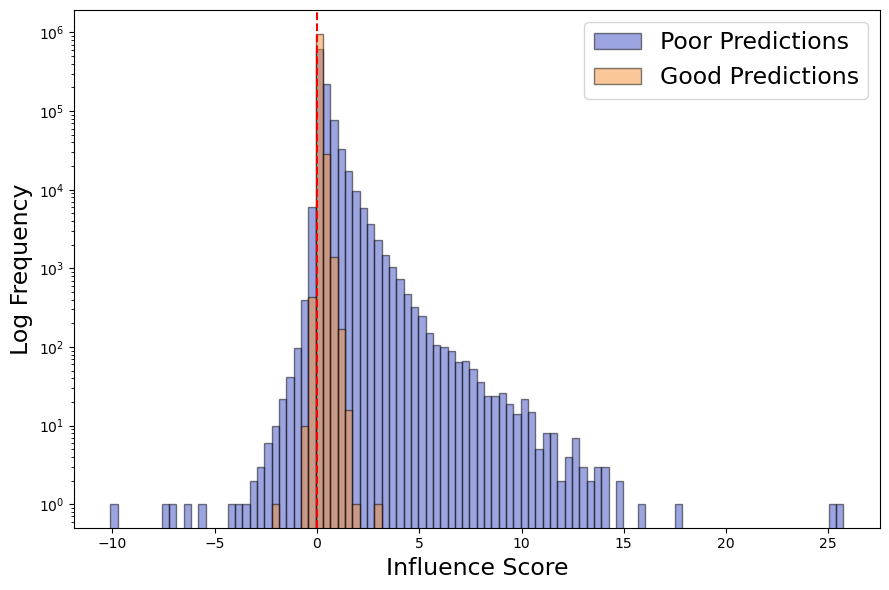

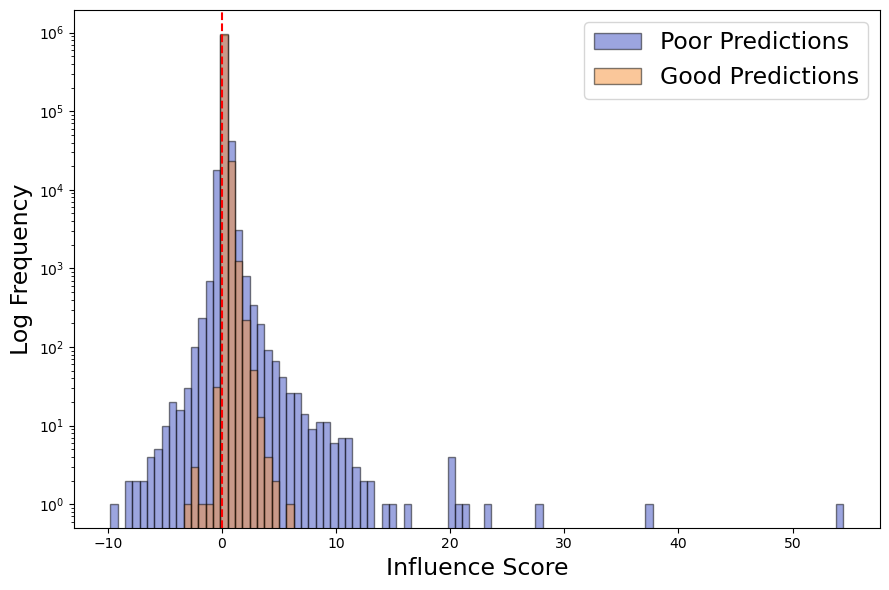

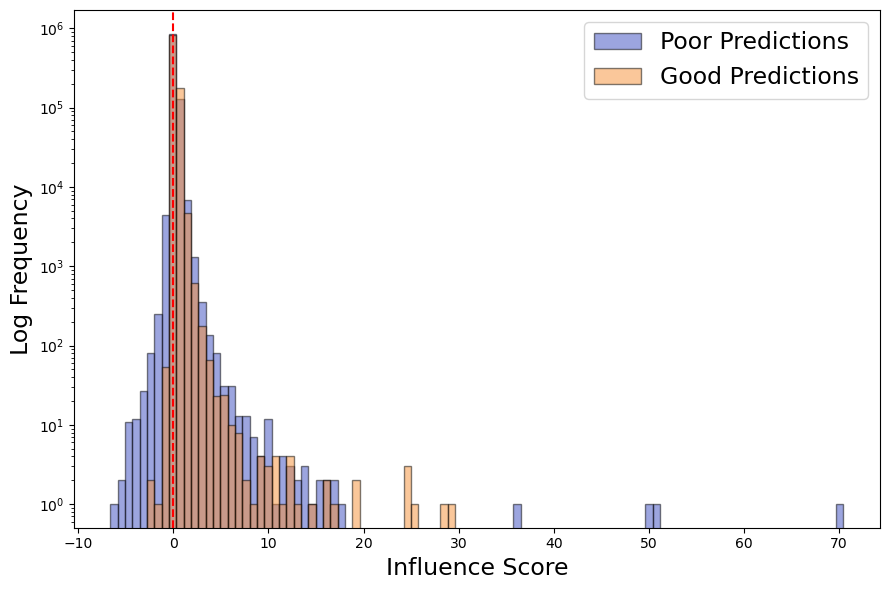

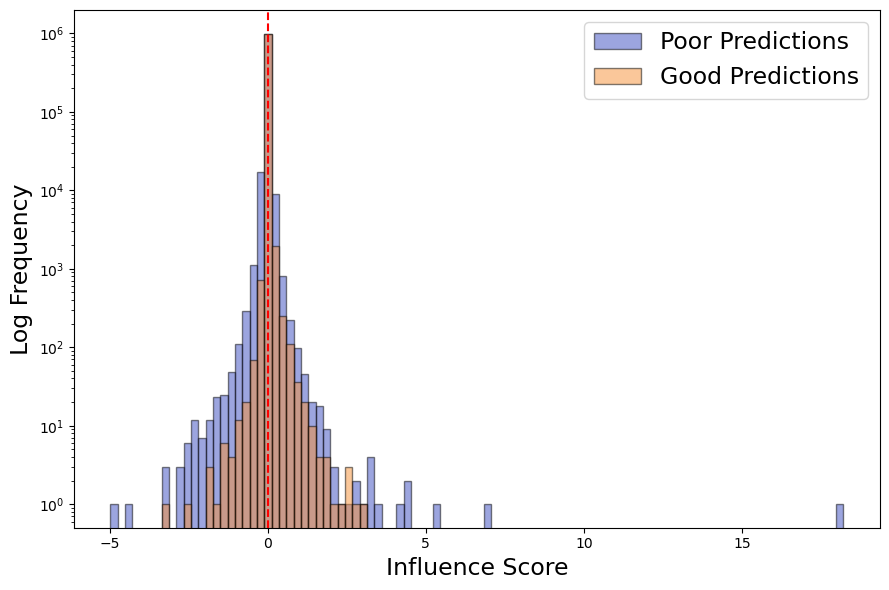

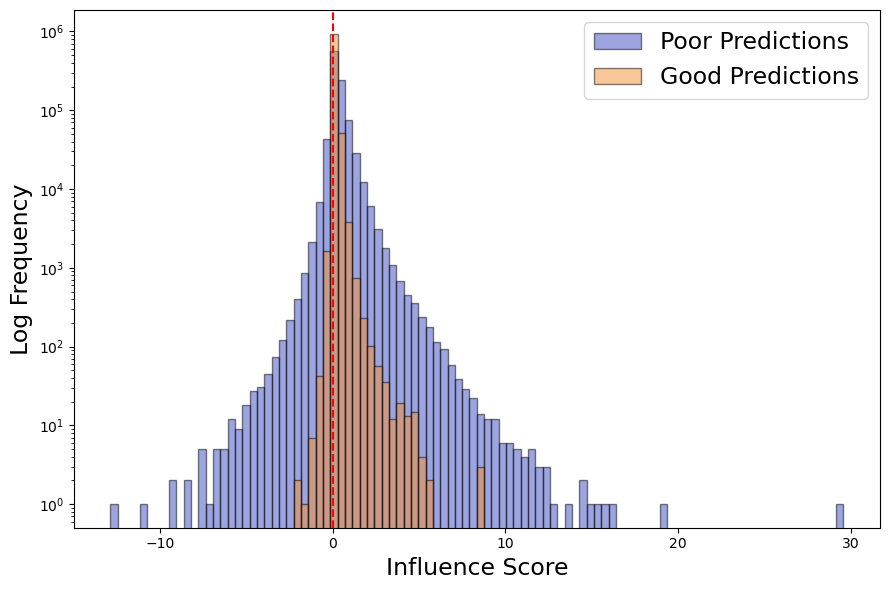

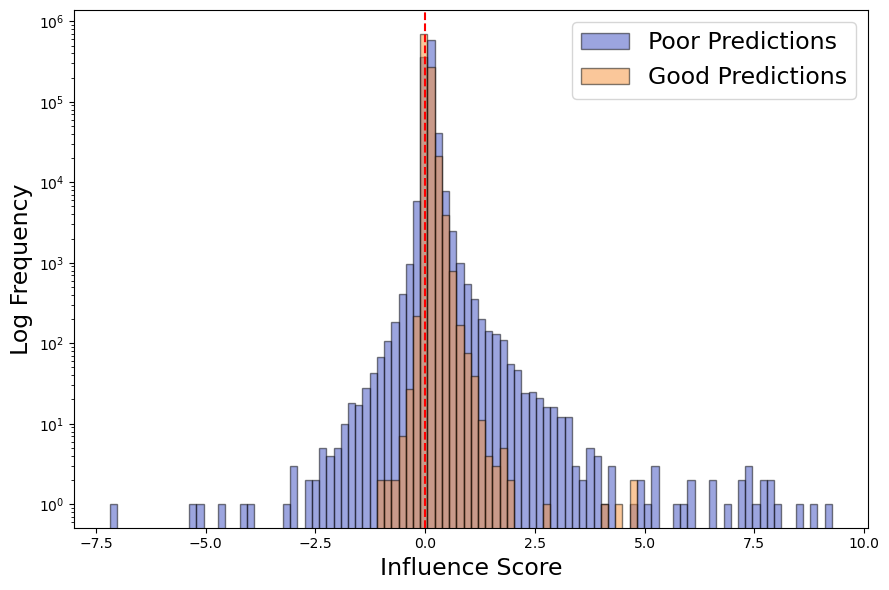

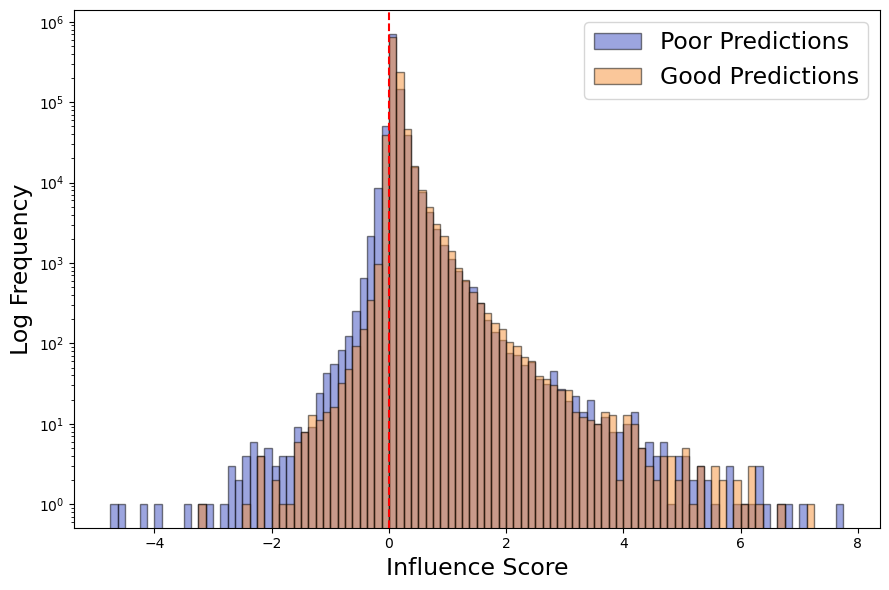

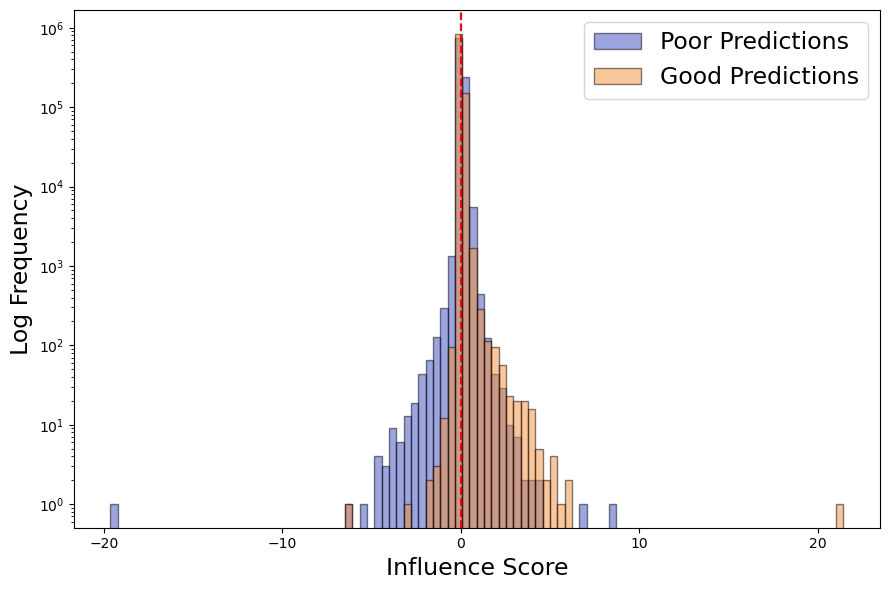

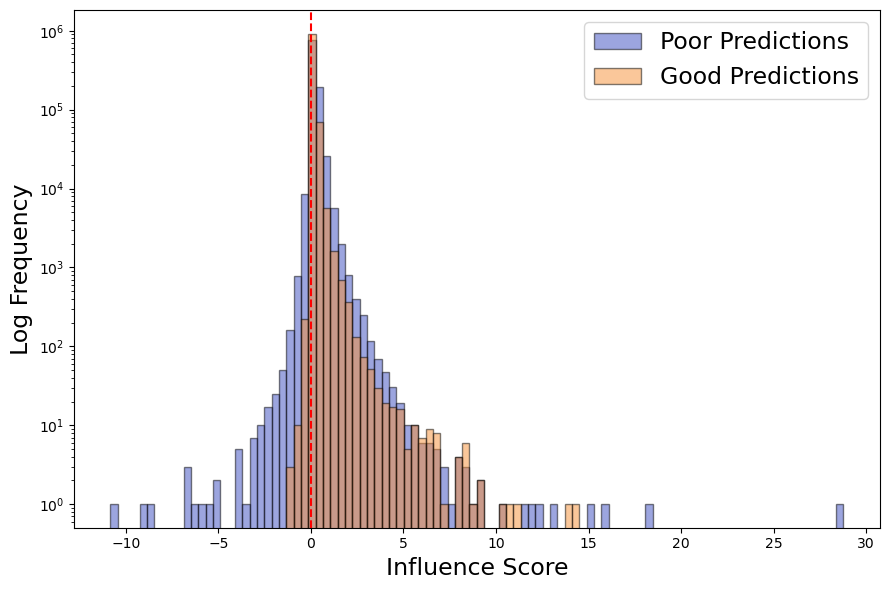

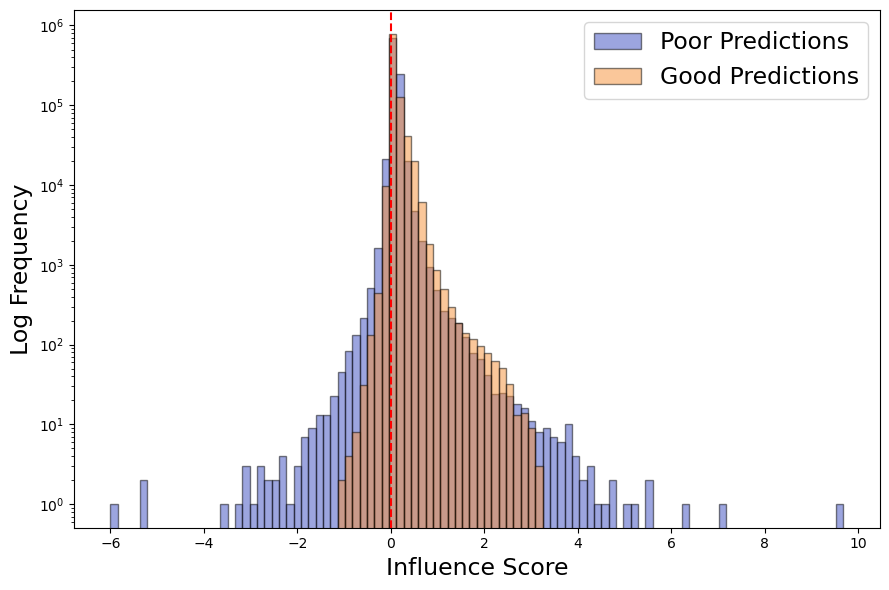

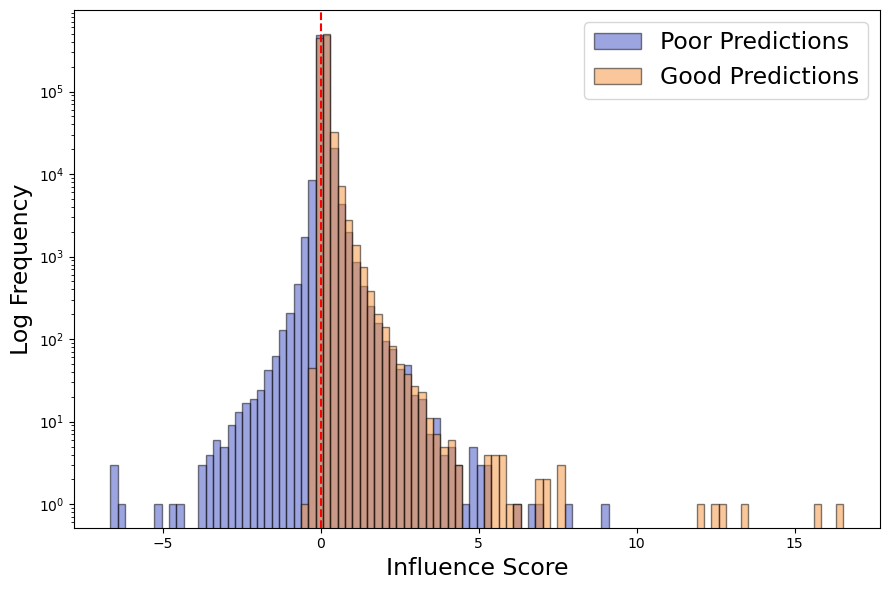

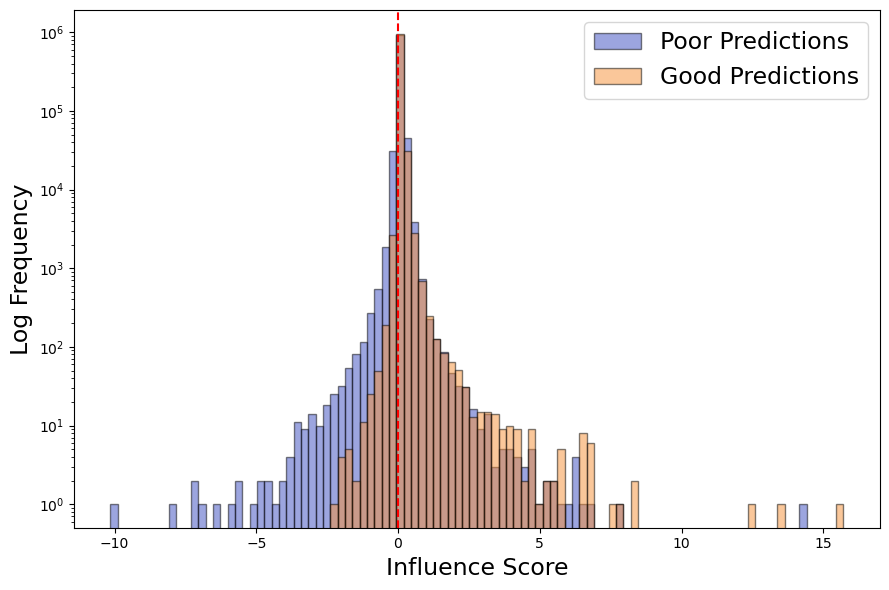

AssertionError: 

In [9]:
# Parameters
n_idx = 100                  # Number of top_k samples to aggregate
n_samples_per_idx = 10000   # Subsample size per sample
bins = 100                # Number of bins
cap_freq = 10000           # Maximum height for histogram bars (for visual cap)

for dataset in datasets:

    current_folder = os.path.join(IF_scores_folder, dataset)

    for model in models:
            
        for split in splits: 

            output_path = os.path.join(plots_folder, f"{dataset}_{model}_{split}_good_bad_predictions.jpg")
            # if os.path.exists(output_path): continue

            current_IF_scores_folder =[f for f in os.listdir(current_folder) if model in f and split in f]
            assert len(current_IF_scores_folder) == 1 
            current_IF_scores_folder = current_IF_scores_folder[0]

            IF_results_folder = os.path.join(current_folder, current_IF_scores_folder)
            train_ids = load_pickle(os.path.join(IF_results_folder, "train_ids.pkl"))
            test_ids = load_pickle(os.path.join(IF_results_folder, "test_ids.pkl"))
            IF_scores = load_pickle(os.path.join(IF_results_folder, "EK-FAC_scores.pkl"))["all_modules"]
            results = load_pickle(os.path.join(IF_results_folder, "test_results.pkl"))
            results = {str(k) if type(k) is not torch.Tensor else str(k.item()) : v["jaccard"] for k, v in results.items()}

            train_ids = {str(i).replace(".pkl", "").strip() : idx for idx, i in enumerate(train_ids)}
            test_ids = {str(i).replace(".pkl", "").strip() : idx for idx, i in enumerate(test_ids)}
            
            top_k_bad = sorted(results.items(), key = lambda x: x[1])[:200]
            top_k_good = sorted(results.items(), key = lambda x: x[1])[-200:][::-1]

            # Containers for scores
            all_scores_bad, all_scores_good = [], [] 

            # Aggregate subsampled scores
            for idx in range(n_idx):
                test_idx_bad = test_ids[top_k_bad[idx][0]]
                test_idx_good = test_ids[top_k_good[idx][0]]

                scores_bad = IF_scores[test_idx_bad, :].ravel()
                scores_good = IF_scores[test_idx_good, :].ravel()

                # Subsample to reduce memory and overplotting
                if len(scores_bad) > n_samples_per_idx:
                    scores_bad = np.random.choice(scores_bad, size=n_samples_per_idx, replace=False)
                if len(scores_good) > n_samples_per_idx:
                    scores_good = np.random.choice(scores_good, size=n_samples_per_idx, replace=False)

                all_scores_bad.append(scores_bad)
                all_scores_good.append(scores_good)

            # Concatenate all subsampled scores
            agg_scores_bad = np.concatenate(all_scores_bad)
            agg_scores_good = np.concatenate(all_scores_good)

            # Determine shared bin range
            range_ = (min(agg_scores_bad.min(), agg_scores_good.min()),
                    max(agg_scores_bad.max(), agg_scores_good.max()))

            # === Plot histograms on log y-scale ===
            fig, ax = plt.subplots(figsize=(9, 6))

            # Plot histograms (not density)
            ax.hist(agg_scores_bad, bins=bins, range=range_, alpha=0.5, label='Poor Predictions', edgecolor = "black", color = bad_color)
            ax.hist(agg_scores_good, bins=bins, range=range_, alpha=0.5, label='Good Predictions', edgecolor = "black", color = good_color)
        
            # Add vertical line at 0
            ax.axvline(x=0, color="red", linestyle="--", linewidth=1.5)

            # Log scale for y-axis
            ax.set_yscale("log")

            # Labels and formatting
            ax.set_xlabel("Influence Score", fontsize = 17)
            ax.set_ylabel("Log Frequency", fontsize = 17)
            ax.legend(fontsize = 17)
            plt.tight_layout()

            # Save figure
            plt.savefig(output_path, bbox_inches="tight")
            plt.show()

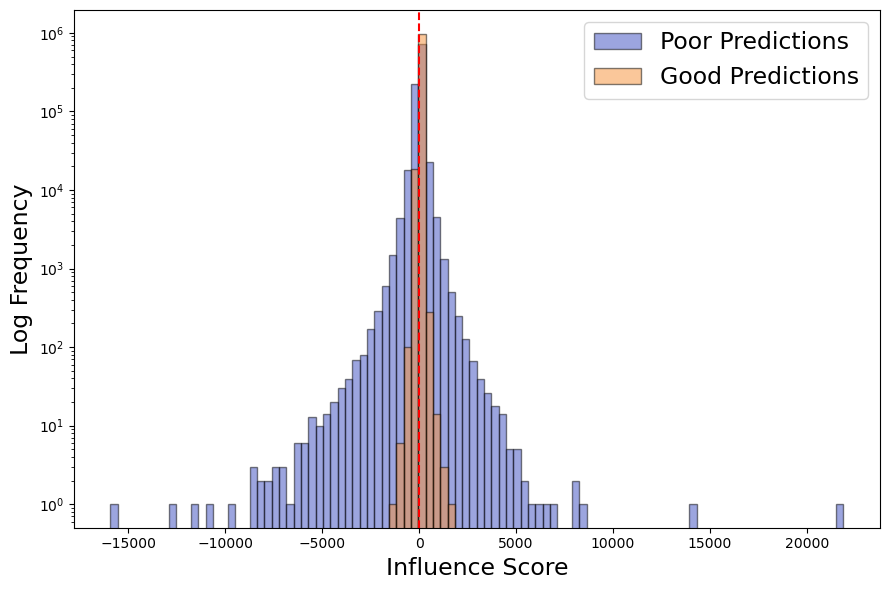

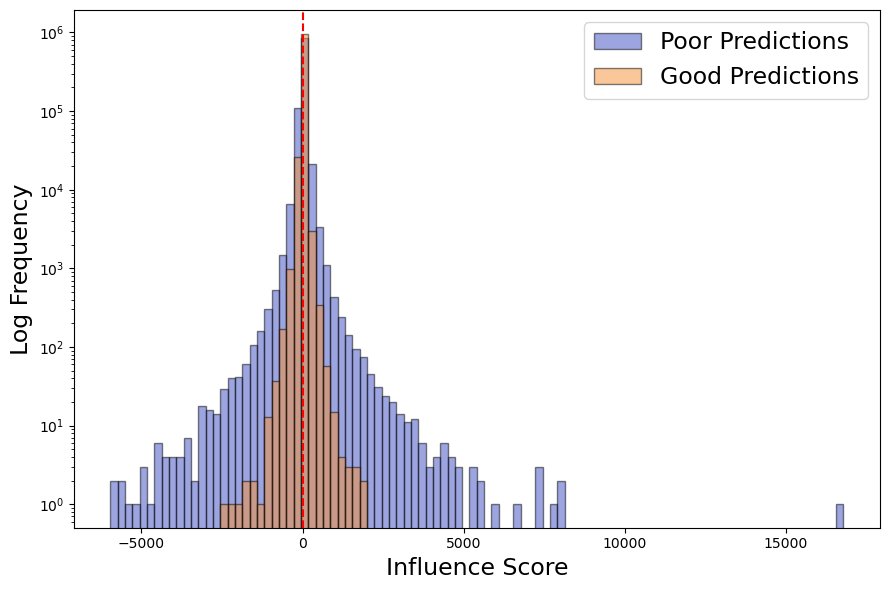

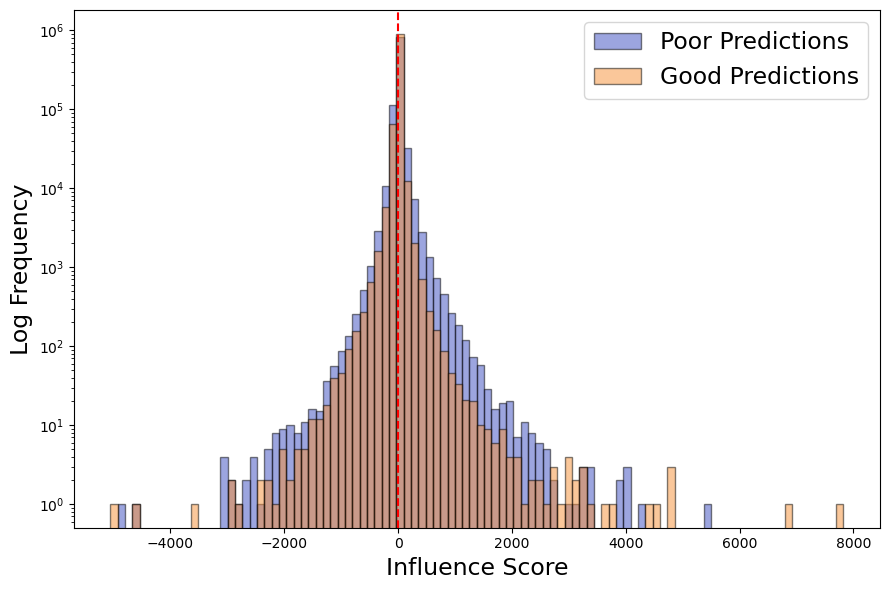

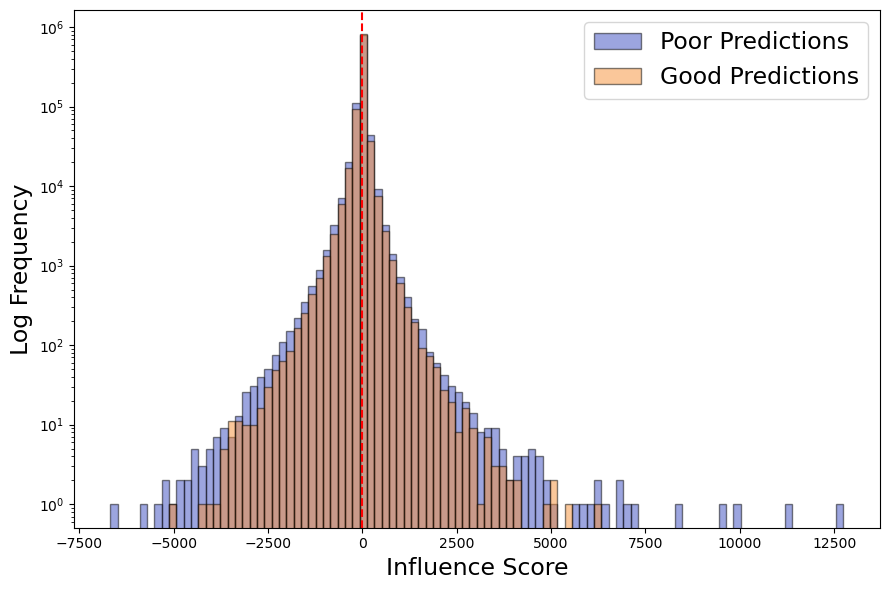

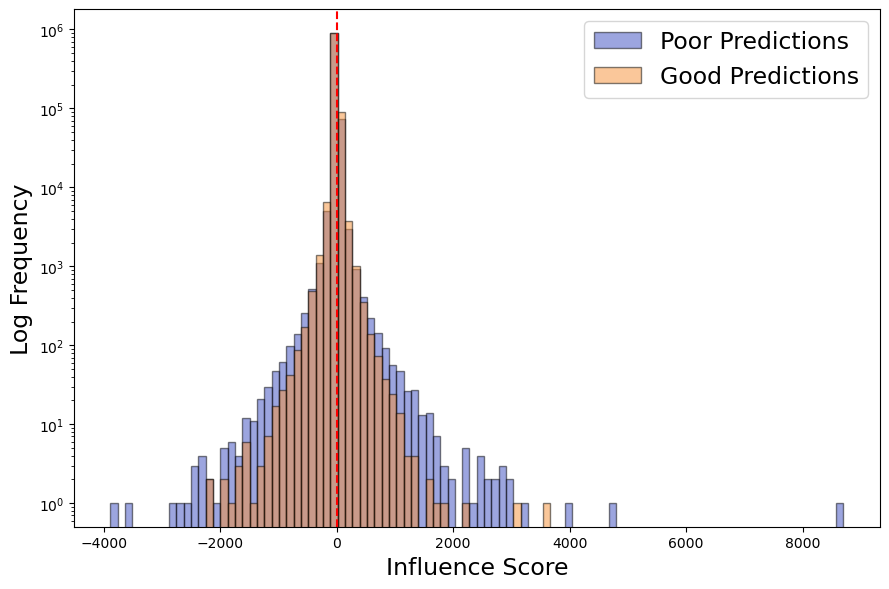

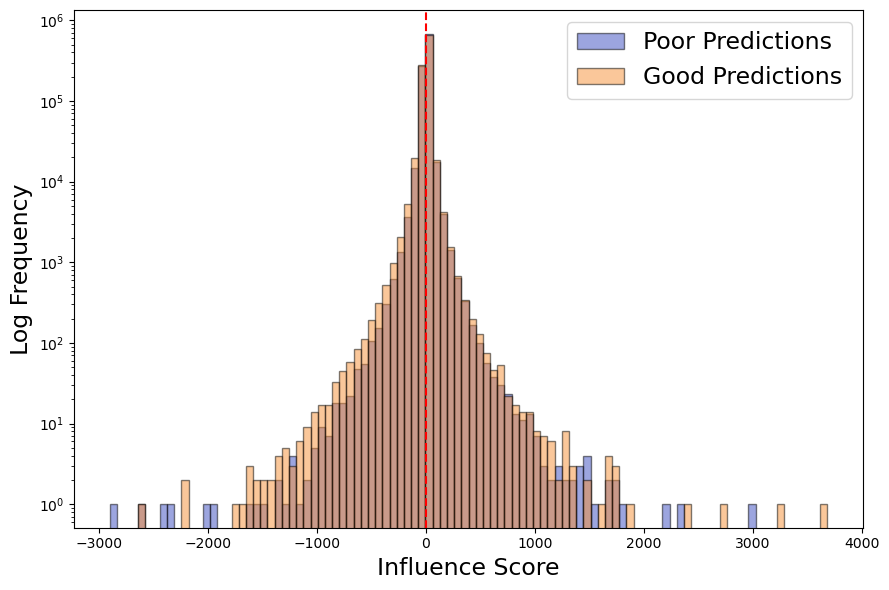

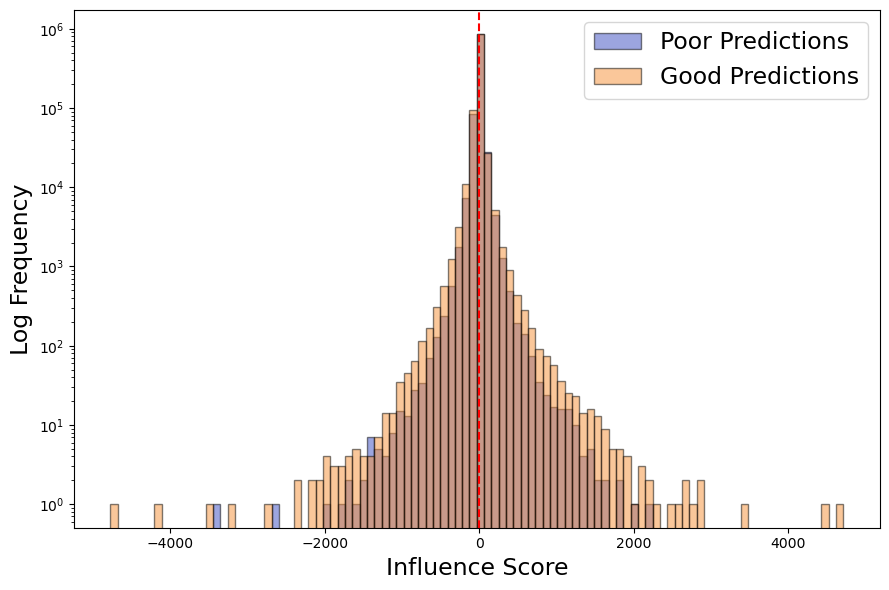

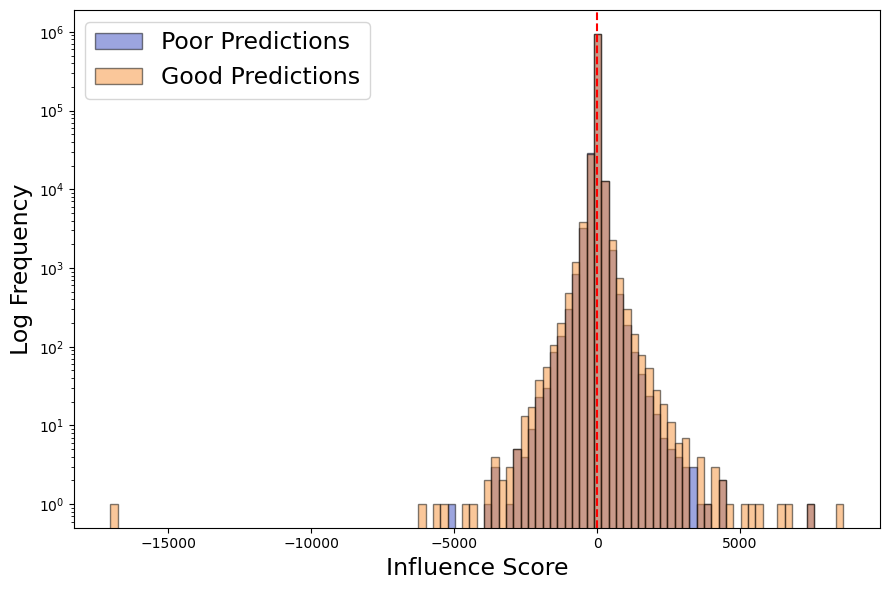

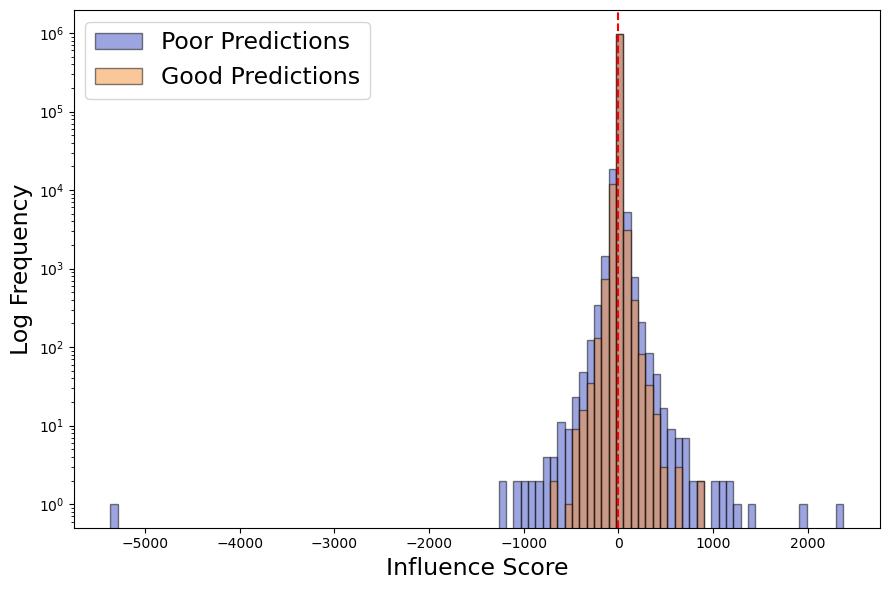

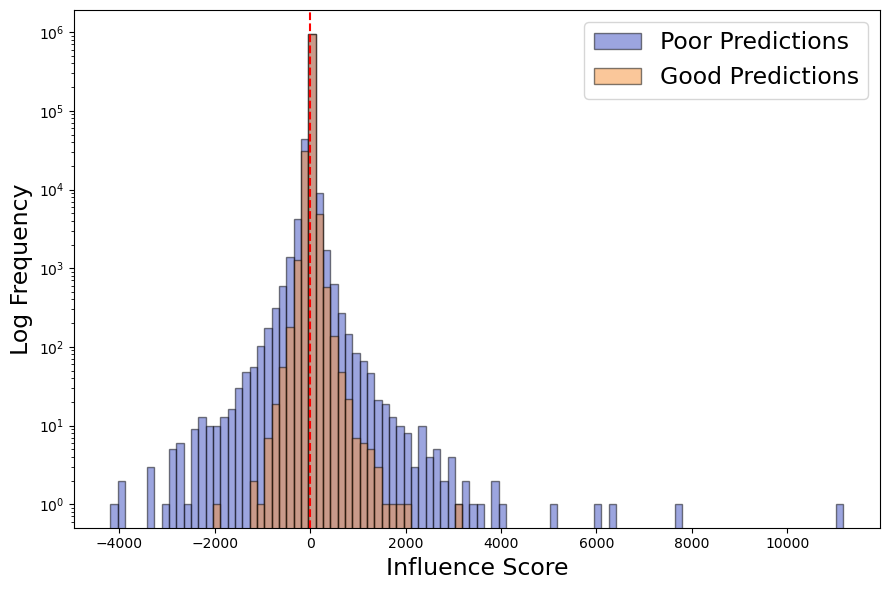

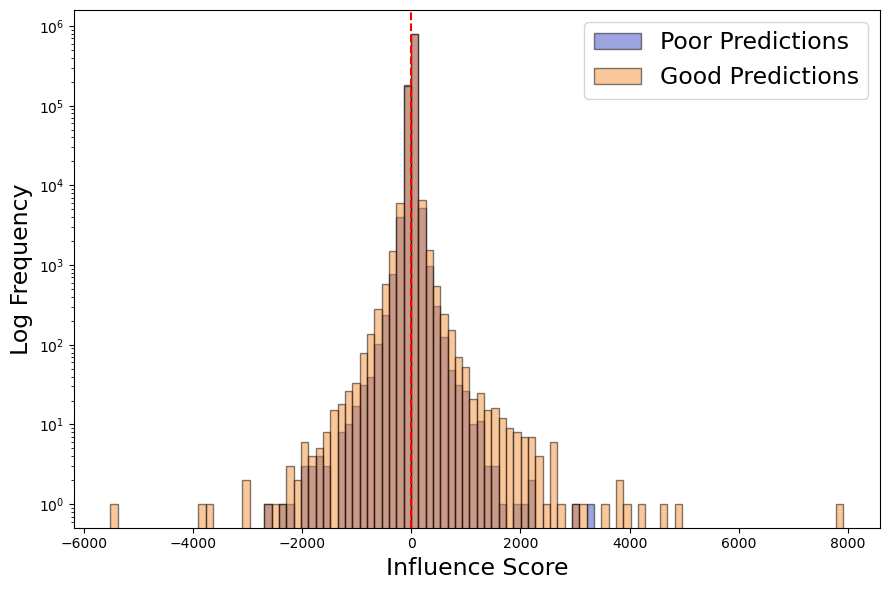

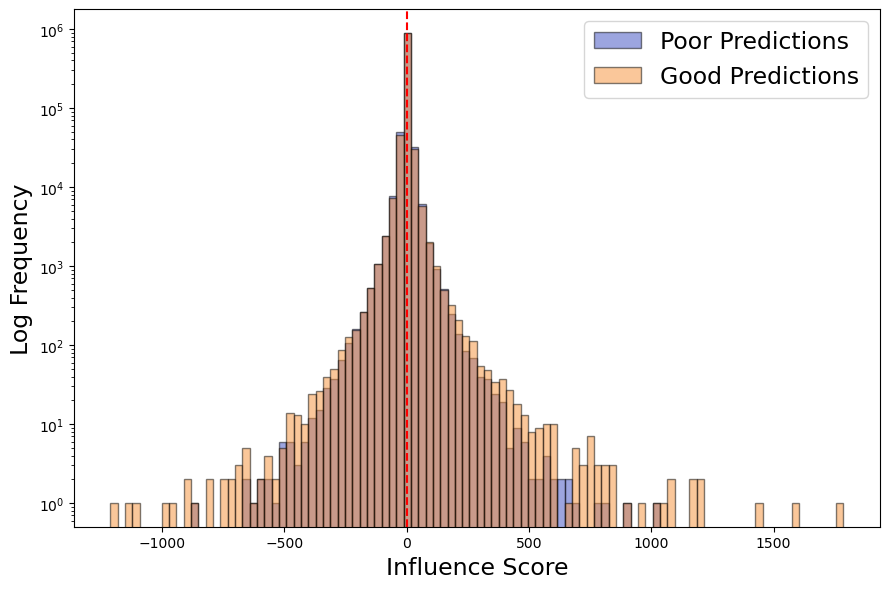

In [8]:
# Parameters
n_idx = 100                  # Number of top_k samples to aggregate
n_samples_per_idx = 10000   # Subsample size per sample
bins = 100                # Number of bins
cap_freq = 10000           # Maximum height for histogram bars (for visual cap)

for dataset in datasets:

    current_folder = os.path.join(IF_scores_folder_MIST, dataset)
    
    for split in splits:

        if split == "LS": 
            current_folder = os.path.join(IF_scores_folder_MIST, f"{dataset}")

        output_path = os.path.join(plots_folder, f"{dataset}_mist_{split}_good_bad_predictions.jpg")
        # if os.path.exists(output_path): continue

        current_IF_scores_folder =[f for f in os.listdir(current_folder) if split in f]
        assert len(current_IF_scores_folder) == 1 
        current_IF_scores_folder = current_IF_scores_folder[0]

        IF_results_folder = os.path.join(current_folder, current_IF_scores_folder)
        train_ids = load_pickle(os.path.join(IF_results_folder, "train_ids.pkl"))
        test_ids = load_pickle(os.path.join(IF_results_folder, "test_ids.pkl"))
        IF_scores = load_pickle(os.path.join(IF_results_folder, "EK-FAC_scores.pkl"))["all_modules"]
        results = load_pickle(os.path.join(IF_results_folder, "test_results.pkl"))
        results = {str(k) if type(k) is not torch.Tensor else str(k.item()) : v["jaccard"] for k, v in results.items()}

        train_ids = {str(i).replace(".ms", "").strip() : idx for idx, i in enumerate(train_ids)}
        test_ids = {str(i).replace(".ms", "").strip() : idx for idx, i in enumerate(test_ids)}
        
        top_k_bad = sorted(results.items(), key = lambda x: x[1])[:100]
        top_k_good = sorted(results.items(), key = lambda x: x[1])[-100:][::-1]

        # Containers for scores
        all_scores_bad, all_scores_good = [], [] 

        # Aggregate subsampled scores
        for idx in range(n_idx):
            if top_k_bad[idx][0] not in test_ids: continue
            if top_k_good[idx][0] not in test_ids: continue
            test_idx_bad = test_ids[top_k_bad[idx][0]]
            test_idx_good = test_ids[top_k_good[idx][0]]

            scores_bad = IF_scores[test_idx_bad, :].ravel()
            scores_good = IF_scores[test_idx_good, :].ravel()

            # Subsample to reduce memory and overplotting
            if len(scores_bad) > n_samples_per_idx:
                scores_bad = np.random.choice(scores_bad, size=n_samples_per_idx, replace=False)
            if len(scores_good) > n_samples_per_idx:
                scores_good = np.random.choice(scores_good, size=n_samples_per_idx, replace=False)

            all_scores_bad.append(scores_bad)
            all_scores_good.append(scores_good)

        # Concatenate all subsampled scores
        agg_scores_bad = np.concatenate(all_scores_bad)
        agg_scores_good = np.concatenate(all_scores_good)

        # Determine shared bin range
        range_ = (min(agg_scores_bad.min(), agg_scores_good.min()),
                max(agg_scores_bad.max(), agg_scores_good.max()))

        # === Plot histograms on log y-scale ===
        fig, ax = plt.subplots(figsize=(9, 6))

        # Plot histograms (not density)
        ax.hist(agg_scores_bad, bins=bins, range=range_, alpha=0.5, label='Poor Predictions', edgecolor = "black", color = bad_color)
        ax.hist(agg_scores_good, bins=bins, range=range_, alpha=0.5, label='Good Predictions', edgecolor = "black", color = good_color)

        # Add vertical line at 0
        ax.axvline(x=0, color="red", linestyle="--", linewidth=1.5)

        # Log scale for y-axis
        ax.set_yscale("log")

        # Labels and formatting
        ax.set_xlabel("Influence Score", fontsize = 17)
        ax.set_ylabel("Log Frequency", fontsize = 17)
        ax.legend(fontsize = 17)
        plt.tight_layout()

        # Save figure
        plt.savefig(output_path, bbox_inches="tight")
        plt.show()

Understand the characteristics of harmful samples

In [7]:
k_train = 50 

for dataset in datasets:

    output_path = os.path.join(cache_folder, f"characteristics_harmful_samples_{dataset}.pkl")
    if os.path.exists(output_path): continue 
    
    print(f"Getting stats for {dataset}")
    consolidated_stats = {}
    
    for model in models: 
        
        current_folder = os.path.join(IF_scores_folder, dataset)
        if model == "MIST_": current_folder = os.path.join(IF_scores_folder_MIST, dataset)

        consolidated_stats[model] = {}
        
        for split in splits: 
            
            current_IF_scores_folder =[f for f in os.listdir(current_folder) if model in f and split in f]
 
            assert len(current_IF_scores_folder) == 1 
            current_IF_scores_folder = current_IF_scores_folder[0]

            results_folder = os.path.join(current_folder, current_IF_scores_folder)
            
            train_ids = load_pickle(os.path.join(results_folder, "train_ids.pkl"))
            test_ids = load_pickle(os.path.join(results_folder, "test_ids.pkl"))
            train_ids = {str(i).replace(".pkl", "").replace(".ms","").strip() : idx for idx, i in enumerate(train_ids)}
            test_ids = {str(i).replace(".pkl", "").replace(".ms","").strip() : idx for idx, i in enumerate(test_ids)}
            
            IF_scores = load_pickle(os.path.join(results_folder, "EK-FAC_scores.pkl"))["all_modules"]

            results = load_pickle(os.path.join(results_folder, "test_results.pkl"))
            results = {str(k) if type(k) is not torch.Tensor else str(k.item()) : v["jaccard"] for k, v in results.items()}

            top_k_bad = sorted(results.items(), key = lambda x: x[1])[:100]

            stats = {}
            count = 0
            
            for (test_id, _) in top_k_bad:

                test_idx = test_ids[test_id]
                test_info = dataset_info[dataset][test_id]

                current_IF_scores = IF_scores[test_idx, :]
                harmful_train_indices = torch.topk(current_IF_scores, k = k_train, largest = False).indices
                harmful_train_values = torch.topk(current_IF_scores, k = k_train, largest = False).values
                harmful_train_list = [(i, idx.item(), harmful_train_values[i].item()) for i, idx in enumerate(harmful_train_indices) if harmful_train_values[i] < 0] # Make sure they are all negatives

                train_id_list = [] 
                mol_sim_list, MS_sim_list, CF_match_over_test_list, CF_match_union_list = [], [], [], []

                # Let us check if all these are different from random 
                train_id_list_random = random.sample(list(train_ids.keys()), k = k_train)
                
                for harmful_train in harmful_train_list:

                    train_id = [k for k,v in train_ids.items() if v == harmful_train[1]][0]

                    train_id_list.append(train_id)
                    train_info = dataset_info[dataset][train_id]
                    
                    mol_sim = compute_mol_sim(test_info["smiles"], train_info["smiles"])
                    MS_sim = compute_MS_sim(test_info, train_info)
                    CF_match_over_test = compute_CF_match_over_test(test_info, train_info)
                    CF_match_union = compute_CF_match_union(test_info, train_info)

                    mol_sim_list.append(mol_sim)
                    MS_sim_list.append(MS_sim)
                    CF_match_over_test_list.append(CF_match_over_test)
                    CF_match_union_list.append(CF_match_union)

                stats[test_id] = {"train_id": train_id_list, 
                                  "mol_sim_list": mol_sim_list,
                                  "MS_sim_list": MS_sim_list,
                                  "CF_match_over_test_list": CF_match_over_test_list,
                                  "CF_match_union_list": CF_match_union_list}

            consolidated_stats[model][split] = stats
    
    pickle_data(consolidated_stats, output_path)

Getting stats for nist2023


In [ ]:
mol_sim_low_threshold = 0.01             
mol_sim_high_threshold = 0.1

MS_sim_low_threshold = 0.01  
MS_sim_high_threshold = 0.9

CF_match_low_threshold = 0.1
CF_match_high_threshold = 0.9

for model in models: 

    counters = {str(i) : 0 for i in range(0, 12)}     

    for dataset in datasets:

        if dataset != "massspecgym": continue
        
        consolidated_stats_path = os.path.join(cache_folder, f"characteristics_harmful_samples_{dataset}.pkl")
        consolidated_stats = load_pickle(consolidated_stats_path)

        if model not in consolidated_stats: continue 

        rec = consolidated_stats[model]

        for split, rec_list in rec.items():
        
            for test_id, stats in rec_list.items():

                mol_sim_list = stats["mol_sim_list"]
                MS_sim_list = stats["MS_sim_list"]
                CF_match_list = stats["CF_match_list"]
                counters["0"] += 1 

                if len(mol_sim_list) == 0: continue

                # Situation 1: mol_sim > high_threshold and MS_sim > high_threshold
                case_1 = [(i, CF_match_list[i]) for i, mol_sim in enumerate(mol_sim_list) if mol_sim > mol_sim_high_threshold and MS_sim_list[i] > MS_sim_high_threshold]
                if len(case_1) > 0: counters["1"] +=1 

                # Situation 2: mol_sim > high_threshold and MS_sim < low_threshold
                case_2 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim > mol_sim_high_threshold and MS_sim_list[i] < MS_sim_low_threshold]
                if len(case_2) > 0: counters["2"] +=1 

                # Situation 3: mol_sim < low_threshold and MS_sim > high_threshold
                case_3 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim < mol_sim_low_threshold and MS_sim_list[i] > MS_sim_high_threshold]
                if len(case_3) > 0: counters["3"] +=1 

                # Situation 4: mol_sim < low_threshold and MS_sim < low_threshold
                case_4 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim < mol_sim_low_threshold and MS_sim_list[i] < MS_sim_low_threshold]
                if len(case_4) > 0: counters["4"] +=1 

                # Situation 5: mol_sim > high_threshold and CF_match > high_threshold
                case_5 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim > mol_sim_high_threshold and CF_match_list[i] > CF_match_high_threshold]
                if len(case_5) > 0: counters["5"] +=1 

                # Situation 6: mol_sim > high_threshold and CF_match < low_threshold
                case_6 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim > mol_sim_high_threshold and CF_match_list[i] < CF_match_low_threshold]
                if len(case_6) > 0: counters["6"] +=1 

                # Situation 7: mol_sim < low_threshold and CF_match > high_threshold
                case_7 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim < mol_sim_low_threshold and CF_match_list[i] > CF_match_high_threshold]
                if len(case_7) > 0: counters["7"] +=1 

                # Situation 8: MS < low_threshold and CF_match < low_threshold
                case_8 = [(i, mol_sim_list[i]) for i, MS_sim in enumerate(MS_sim_list) if MS_sim < MS_sim_low_threshold and CF_match_list[i] < CF_match_low_threshold]
                if len(case_8) > 0: counters["8"] +=1 

                # Situation 9: MS < low_threshold and CF_match > high_threshold
                case_9 = [i for i, MS_sim in enumerate(MS_sim_list) if MS_sim < MS_sim_low_threshold and CF_match_list[i] > CF_match_high_threshold]
                if len(case_9) > 0: counters["9"] +=1 

                # Situation 10: MS > high_threshold and CF_match > high_threshold
                case_10 = [i for i, MS_sim in enumerate(MS_sim_list) if MS_sim > MS_sim_high_threshold and CF_match_list[i] > CF_match_high_threshold]
                if len(case_10) > 0: counters["10"] +=1 

                # Situation 11: MS > high_threshold and CF_match < low_threshold
                case_11 = [i for i, MS_sim in enumerate(MS_sim_list) if MS_sim > MS_sim_high_threshold and CF_match_list[i] < CF_match_low_threshold]
                if len(case_11) > 0: counters["11"] +=1 

    # counters = {k: round(v/counters["0"] * 100, 3) for k,v in counters.items() if k != "0"}
    print(model, sorted(counters.items(), key = lambda x: x[1], reverse = True))

In [ ]:




# # Situation 1: mol_sim > high_threshold and MS_sim > high_threshold
# case_1 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim > mol_sim_high_threshold and MS_sim_list[i] > MS_sim_high_threshold]
# if len(case_1) > 0: counters["1"] +=1 

# # Situation 2: mol_sim > high_threshold and MS_sim < low_threshold
# case_2 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim > mol_sim_high_threshold and MS_sim_list[i] < MS_sim_low_threshold]
# if len(case_2) > 0: counters["2"] +=1 

# # Situation 3: mol_sim < low_threshold and MS_sim > high_threshold
# case_3 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim < mol_sim_low_threshold and MS_sim_list[i] > MS_sim_high_threshold]
# if len(case_3) > 0: counters["3"] +=1 

# # Situation 4: mol_sim < low_threshold and MS_sim < low_threshold
# case_4 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim < mol_sim_low_threshold and MS_sim_list[i] < MS_sim_low_threshold]
# if len(case_4) > 0: counters["4"] +=1 

# # Situation 5: mol_sim > high_threshold and CF_match > high_threshold
# case_5 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim > mol_sim_high_threshold and CF_match_list[i] > CF_match_high_threshold]
# if len(case_5) > 0: counters["5"] +=1 

# # Situation 6: mol_sim > high_threshold and CF_match < low_threshold
# case_6 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim > mol_sim_high_threshold and CF_match_list[i] < CF_match_low_threshold]
# if len(case_6) > 0: counters["6"] +=1 

# # Situation 7: mol_sim < low_threshold and CF_match > high_threshold
# case_7 = [i for i, mol_sim in enumerate(mol_sim_list) if mol_sim < mol_sim_low_threshold and CF_match_list[i] > CF_match_high_threshold]
# if len(case_7) > 0: counters["7"] +=1 

# # Situation 8: MS < low_threshold and CF_match < low_threshold
# case_8 = [i for i, MS_sim in enumerate(MS_sim_list) if MS_sim < MS_sim_low_threshold and CF_match_list[i] < CF_match_low_threshold]
# if len(case_8) > 0: counters["8"] +=1 

# # Situation 9: MS < low_threshold and CF_match > high_threshold
# case_9 = [i for i, MS_sim in enumerate(MS_sim_list) if MS_sim < MS_sim_low_threshold and CF_match_list[i] > CF_match_high_threshold]
# if len(case_9) > 0: counters["9"] +=1 

# # Situation 10: MS > high_threshold and CF_match > high_threshold
# case_10 = [i for i, MS_sim in enumerate(MS_sim_list) if MS_sim > MS_sim_high_threshold and CF_match_list[i] > CF_match_high_threshold]
# if len(case_10) > 0: counters["10"] +=1 

# # Situation 11: MS > high_threshold and CF_match < low_threshold
# case_11 = [i for i, MS_sim in enumerate(MS_sim_list) if MS_sim > MS_sim_high_threshold and CF_match_list[i] < CF_match_low_threshold]
# if len(case_11) > 0: counters["11"] +=1 


In [ ]:
?np.percentile

In [ ]:
import scipy
scipy.stats.ttest_rel(mol_sim_list_random, mol_sim_list)
scipy.stats.ttest_rel(MS_sim_list_random, MS_sim_list)

scipy.stats.ttest_rel(CF_match_list_random, CF_match_list)




In [ ]:
np.mean(CF_match_list)

In [ ]:
np.mean(CF_match_list_random)

In [ ]:
np.mean(mol_sim_list_random), np.mean(mol_sim_list)

In [ ]:
np.mean(MS_sim_list_random), np.mean(MS_sim_list)

In [ ]:
np.mean(CF_match_list_random), np.mean(CF_match_list)

In [ ]:
                mol_sim_low_threshold = np.percentile(mol_sim_list, 0.2)                
                mol_sim_high_threshold = np.percentile(mol_sim_list, 0.8)

                MS_sim_low_threshold = np.percentile(MS_sim_list, 0.2)                
                MS_sim_high_threshold = np.percentile(MS_sim_list, 0.8)

                CF_match_low_threshold = np.percentile(CF_match_list, 0.2)                
                CF_match_high_threshold = np.percentile(CF_match_list, 0.8)